# Predicting expression of ESR1 using single cell data 

We use XGBoost to predict the expression of a gene based on the expression of the other genes in the cell.

In [423]:
import pandas as pd
from src.grid_search import create_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import pickle
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

from src.modules import train_test_val_split, plot_prediction, shap_tester, plot_importance, plot_training_xgb, XGB_CV
from src.data_handling import transpose_set_ind, compute_correlation, root_mse, count_non_nans

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
df = pd.read_pickle("/data/severs/rna_scaled_cancer_T_NaN.pkl")

In [424]:
with open('/data/severs/high_q_cell_names.pkl', 'rb') as handle:
    high_quality_cells = pickle.load(handle)

In [447]:
df = df.loc[high_quality_cells["Cancer"]]

In [448]:
correlation, p_values, n = compute_correlation(df, "ESR1", fdr=True)

  0%|          | 0/28635 [00:00<?, ?it/s]

divide by zero encountered in double_scalars


In [449]:
ESR1_df = pd.DataFrame()

In [450]:
ESR1_df = ESR1_df.append(pd.Series(correlation, name="Correlation"))
ESR1_df = ESR1_df.append(pd.Series(p_values, name="FDR p-values"))

In [451]:
ESR1_df = ESR1_df.append(pd.Series(n, name="# non-NaNs"))

In [452]:
ESR1_df.columns = df.columns

In [75]:
ESR1_df.to_pickle("/data/severs/ESR1_correlation_p_values.pkl")

In [453]:
ESR1_df = ESR1_df.T

In [454]:
ESR1_df = ESR1_df[ESR1_df['# non-NaNs'] > 0.8*df.shape[0]]

In [455]:
ESR1_df = ESR1_df[ESR1_df['FDR p-values'] < 0.05]

In [456]:
input_variables = ESR1_df.sort_values("Correlation").index[-1001:-1]

In [457]:
X = df[input_variables]
Y = df.ESR1

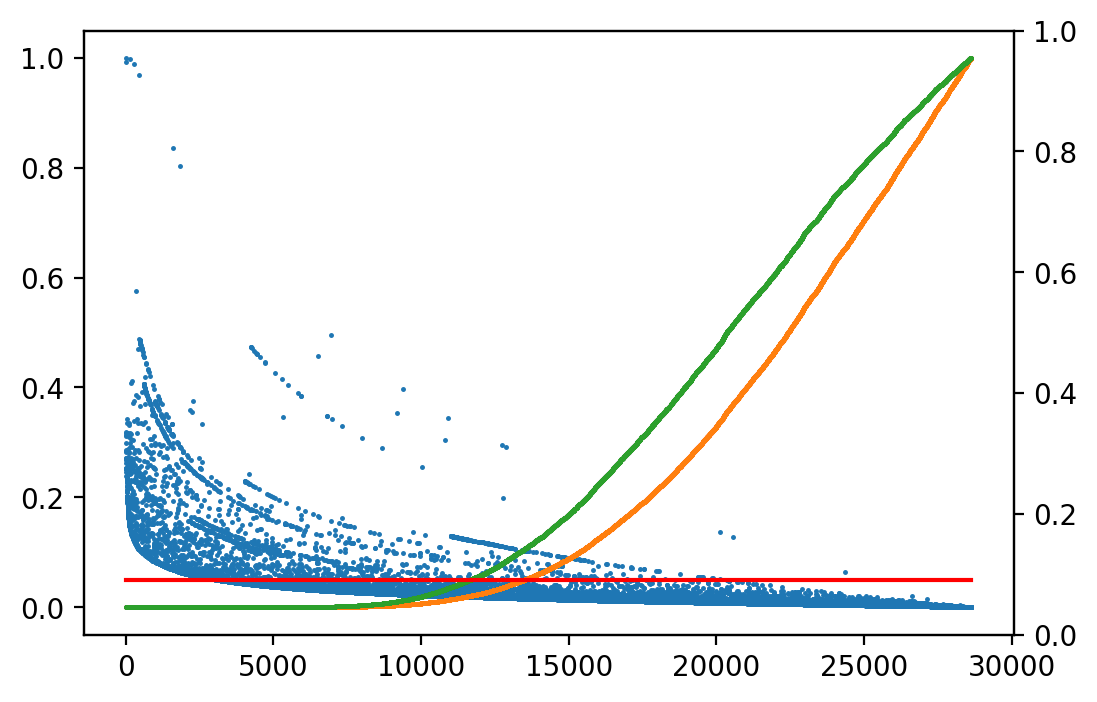

In [42]:
fig, ax = plt.subplots(dpi=200)
ax.scatter(np.arange(28635),abs(correlation[sorter]), s=0.6)
ax.scatter(np.arange(28635),p_values[sorter]*2, s=0.3)
ax.scatter(np.arange(28635),fdr[1][sorter], s=0.3)
ax.plot((0,28635), (0.05, 0.05), color="r")
ax2 = ax.twinx()

In [234]:
df_new = pd.read_csv("/data/xiaoral/ESR1_cancer_corr.csv")

In [245]:
df_new = df_new.sort_values("ESR1_pvals")

In [248]:
df_new

,Unnamed: 0,cor_pearson,ESR1_pvals,ESR1_padjust
18645,LINC00508,9.918604e-01,0.000000,0.000000
16345,ANKRD30A,3.182781e-01,0.000000,0.000000
8511,STC2,3.173193e-01,0.000000,0.000000
3651,AFF3,3.142950e-01,0.000000,0.000000
16999,GFRA1,3.110341e-01,0.000000,0.000000
...,...,...,...,...
18536,RP11-173P15.9,-5.136561e-06,0.999573,0.999713
28231,CH507-154B10.1,-3.504492e-06,0.999644,0.999748
12602,SMIM18,3.083198e-06,0.999695,0.999765
16285,RP11-85G18.6,2.419339e-06,0.999755,0.999789


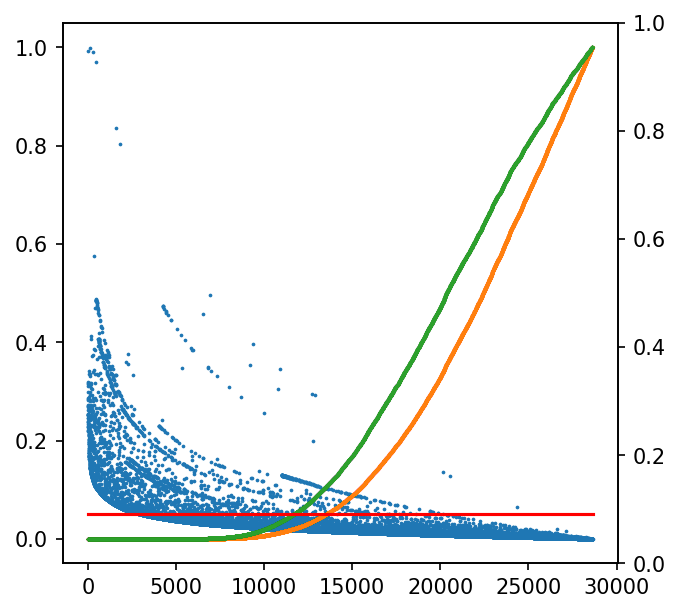

In [251]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(np.arange(28634),abs(df_new.cor_pearson), s=0.6)
ax.scatter(np.arange(28634),df_new.ESR1_pvals, s=0.3)
ax.scatter(np.arange(28634),df_new.ESR1_padjust, s=0.3)
ax.plot((0,28635), (0.05, 0.05), color="r")
ax2 = ax.twinx()

In [236]:
df_new

,Unnamed: 0,cor_pearson,ESR1_pvals,ESR1_padjust
0,RP11-34P13.3,-0.002411,0.912028,0.948430
1,RP11-34P13.7,-0.000186,0.981236,0.989530
2,RP11-34P13.8,-0.013423,0.259052,0.393826
3,FO538757.3,0.017909,0.026310,0.061838
4,FO538757.2,0.010062,0.199834,0.322859
...,...,...,...,...
28629,AC023491.2,0.013891,0.610368,0.733888
28630,AC004556.1,0.002263,0.785676,0.864473
28631,AC233755.2,0.011715,0.227133,0.356291
28632,AC233755.1,0.019461,0.030943,0.070955


# Simple first model

In [111]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [112]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", seed=1, eta=0.03, n_estimators=1000, n_jobs=80, max_depth=3)

In [121]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X, Y)

In [122]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [123]:
%time xgb_model.fit(X_train, y_train, verbose=False, early_stopping_rounds=30, eval_set = eval_set)

CPU times: user 19min 45s, sys: 8.69 s, total: 19min 53s
Wall time: 15 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.0299999993, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=80, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [124]:
y_pred_xgb = xgb_model.predict(X_test)

In [125]:
y_pred_xgb_val = xgb_model.predict(X_val)

In [126]:
y_pred_xgb_train = xgb_model.predict(X_train)

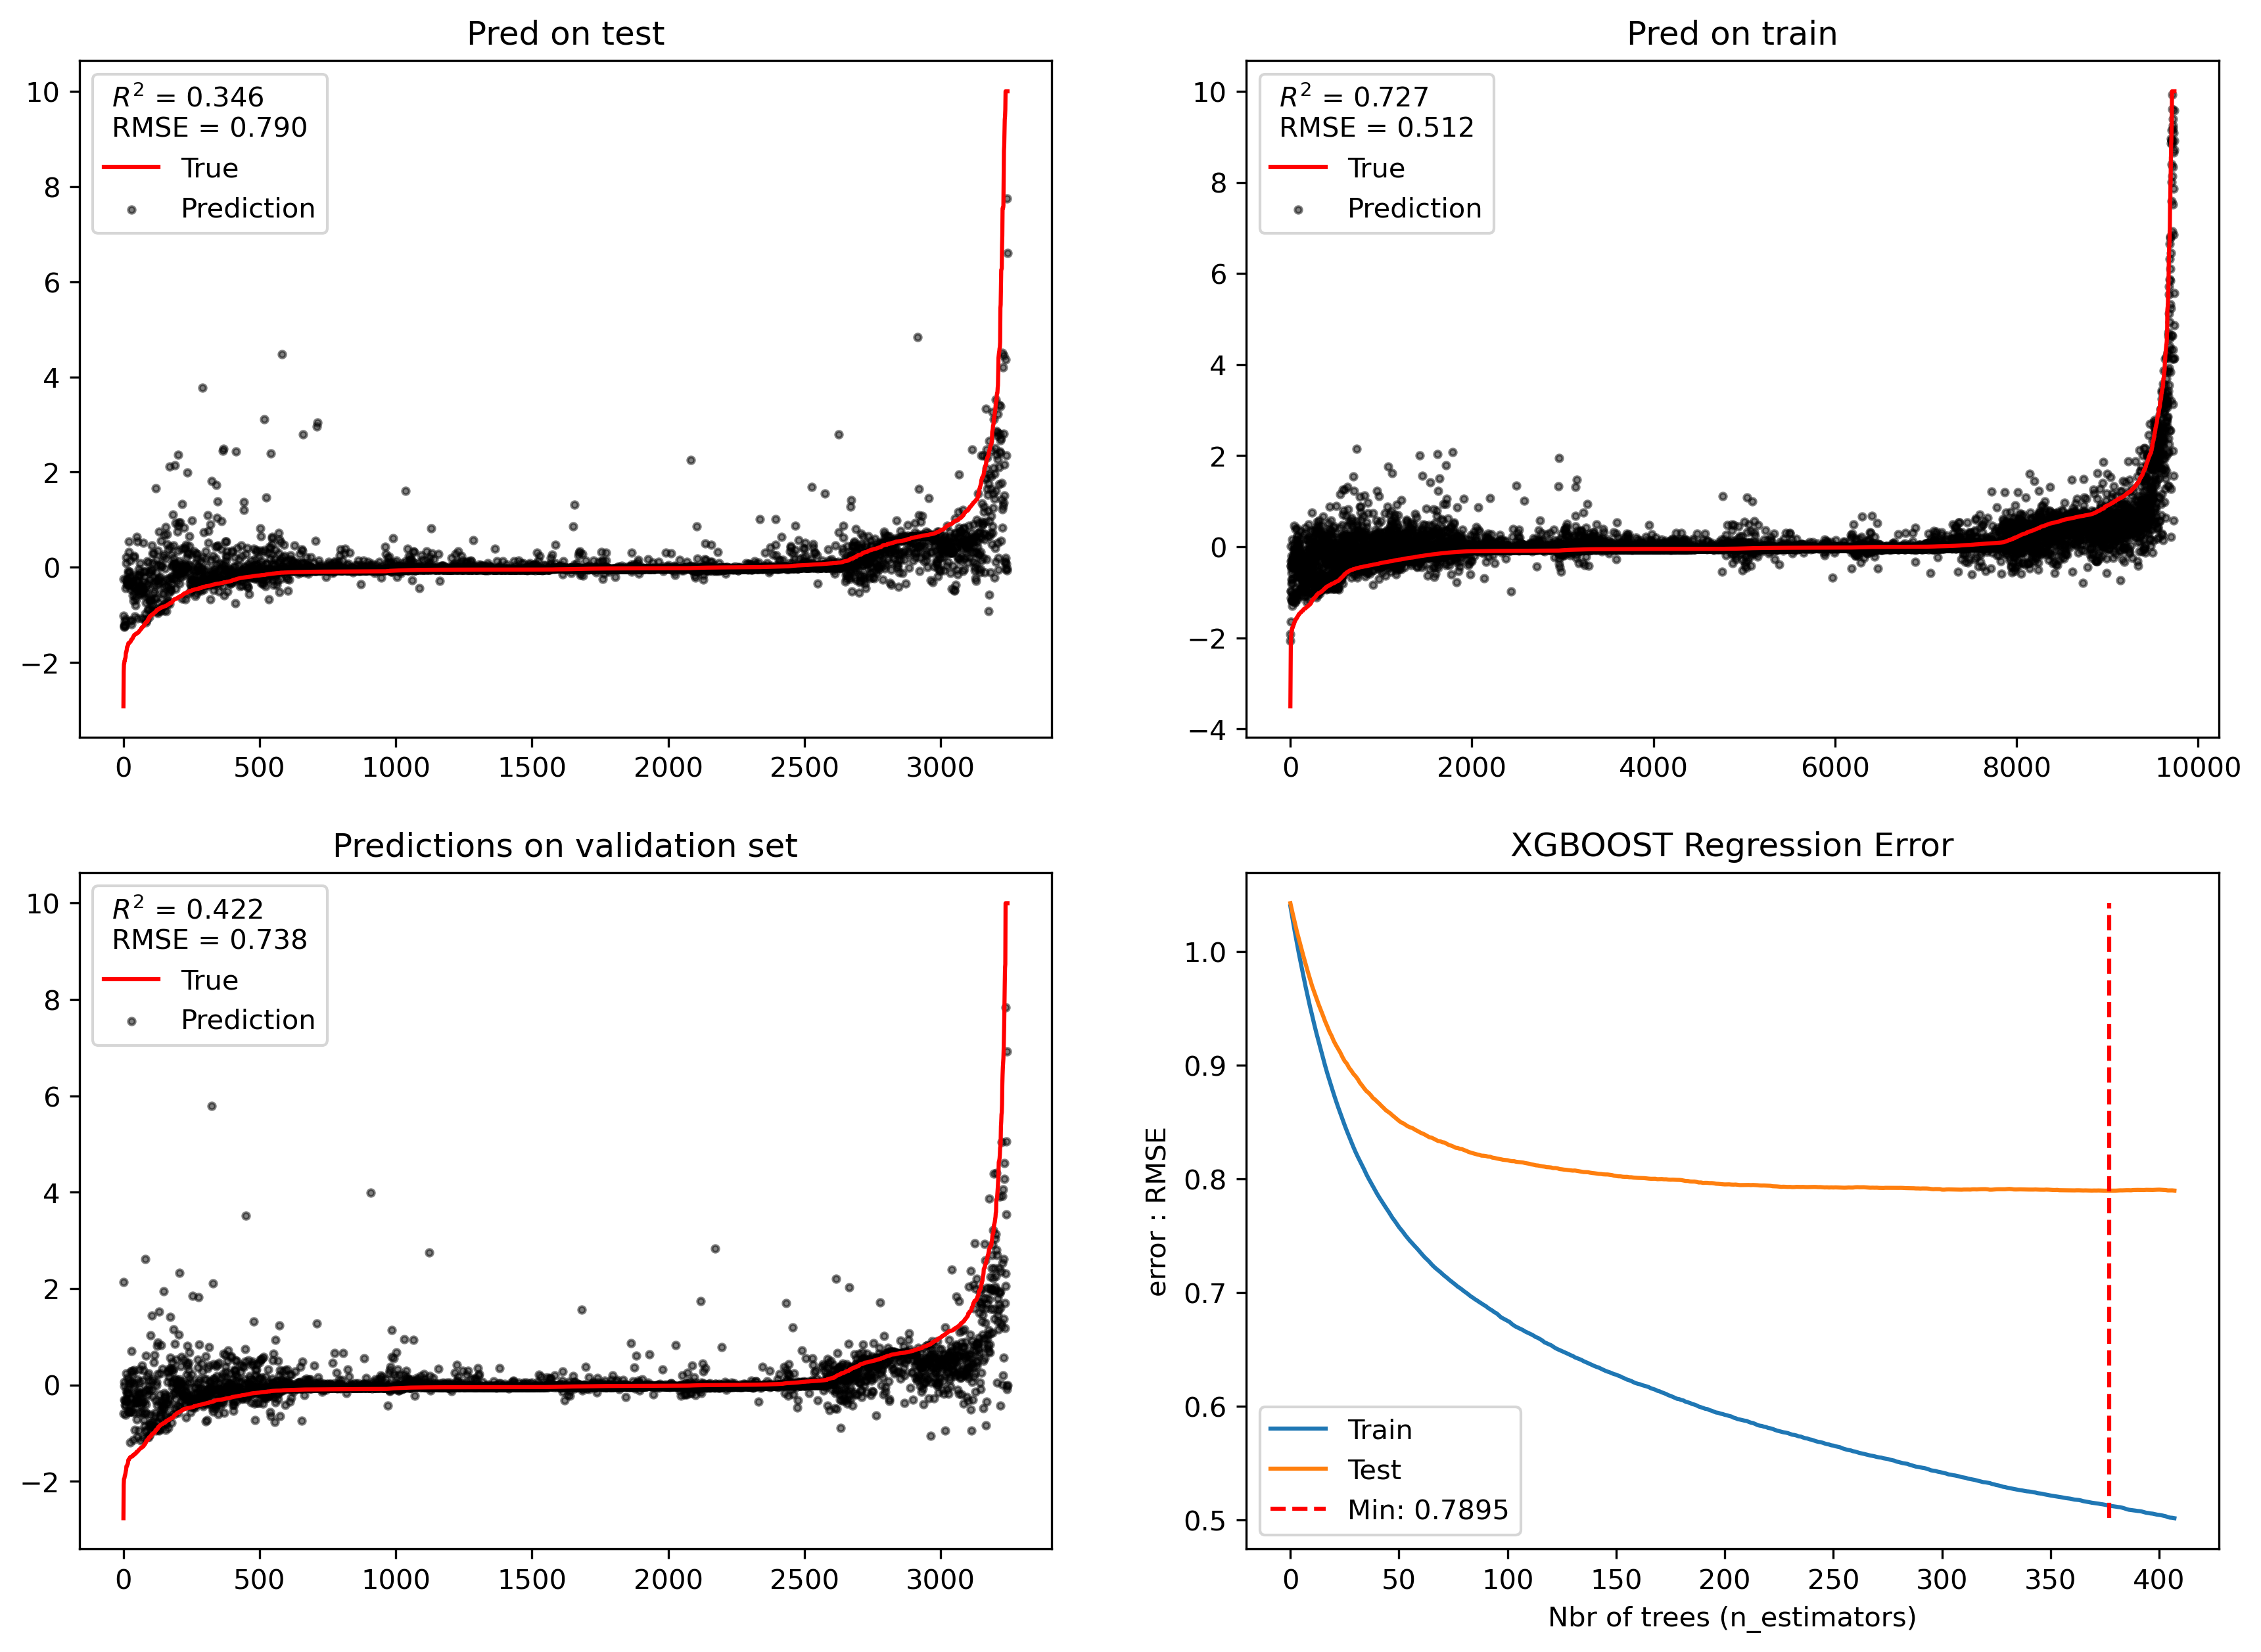

In [127]:
fig, axes = plt.subplots(2,2, figsize=(14,10), dpi=300)
plot_prediction(y_test, y_pred_xgb, fig=fig, ax=axes[0][0], title="Pred on test");
plot_prediction(y_val, y_pred_xgb_val, fig=fig, ax=axes[1][0], title="Predictions on validation set");
plot_prediction(y_train, y_pred_xgb_train, fig=fig, ax=axes[0][1], title="Pred on train");
plot_training_xgb(xgb_model.evals_result_, fig=fig, ax=axes[1][1], title="Training error")
fig.savefig("predictions.png", dpi=300)

# Model tuning ESR1

We do a stepwise tuning where we tune groups of parameters instead of all at once to save computing power

In [700]:
from src.model_selection import XGBGridSearch

In [687]:
# The base model used for tuning
xgb1 = XGBRegressor(objective="reg:squarederror", 
                   seed=1, 
                   learning_rate=0.03, 
                   n_estimators=1000, 
                   n_jobs=80, max_depth=3, 
                   colsample_bytree=1,
                   subsample=1, verbosity=0, silent=True)

In [672]:
X = df[input_variables]
Y = df.ESR1

In [673]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [680]:
param_test1 = {
   'learning_rate' : [0.01, 0.03, 0.07, 0.1, 0.15],
    'max_depth' : [3,5,7]
}

In [762]:
GS1 = XGBGridSearch(xgb1, param_test1, cv=5)

In [689]:
GS1.fit(X, Y)

Fitting 5 folds for each of 15 candidates, totalling 75 candidates.
Fitting candidate 1 of 15
    learning_rate : 0.01     max_depth : 3 
    Test Result: 0.8183     std: 0.0402       n iter: 600
    Train Result: 0.6395     std: 0.0091


Fitting candidate 2 of 15
    learning_rate : 0.01     max_depth : 5 
    Test Result: 0.8095     std: 0.0413       n iter: 600
    Train Result: 0.4602     std: 0.0074


Fitting candidate 3 of 15
    learning_rate : 0.01     max_depth : 7 
    Test Result: 0.8237     std: 0.0330       n iter: 600
    Train Result: 0.3028     std: 0.0067


Fitting candidate 4 of 15
    learning_rate : 0.03     max_depth : 3 
    Test Result: 0.8126     std: 0.0385       n iter: 377
    Train Result: 0.5606     std: 0.0071


Fitting candidate 5 of 15
    learning_rate : 0.03     max_depth : 5 
    Test Result: 0.8053     std: 0.0378       n iter: 308
    Train Result: 0.3924     std: 0.0072


Fitting candidate 6 of 15
    learning_rate : 0.03     max_depth : 7 
    Tes

array([[0.81828  , 0.8094724, 0.8237374],
       [0.812628 , 0.8052946, 0.8210024],
       [0.813352 , 0.8098998, 0.828257 ],
       [0.8107044, 0.8143066, 0.8284724],
       [0.8209286, 0.818097 , 0.8346214]])

(None,
 <AxesSubplot:title={'center':'Grid search for max_depth and learning_rate'}, xlabel='max_depth', ylabel='learning_rate'>)

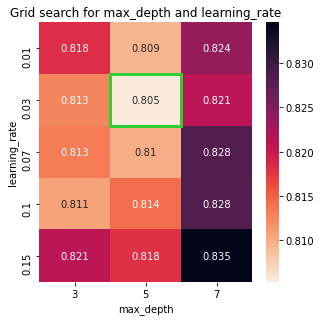

In [690]:
GS1.plot_search(title="Grid search for max_depth and learning_rate")

In [691]:
param_test2 = {
   'learning_rate' : [0.02, 0.03, 0.04],
    'max_depth' : [4,5,6]
}

In [692]:
GS2 = XGBGridSearch(xgb1, param_test2, cv=5)

In [694]:
GS2.fit(X, Y)

Fitting 5 folds for each of 9 candidates, totalling 45 candidates.
Fitting candidate 1 of 9
    learning_rate : 0.02     max_depth : 4 
    Test Result: 0.8075     std: 0.0392       n iter: 600
    Train Result: 0.4457     std: 0.0093


Fitting candidate 2 of 9
    learning_rate : 0.02     max_depth : 5 
    Test Result: 0.8052     std: 0.0394       n iter: 462
    Train Result: 0.3921     std: 0.0077


Fitting candidate 3 of 9
    learning_rate : 0.02     max_depth : 6 
    Test Result: 0.8172     std: 0.0386       n iter: 422
    Train Result: 0.3175     std: 0.0048


Fitting candidate 4 of 9
    learning_rate : 0.03     max_depth : 4 
    Test Result: 0.8090     std: 0.0391       n iter: 324
    Train Result: 0.4779     std: 0.0090


Fitting candidate 5 of 9
    learning_rate : 0.03     max_depth : 5 
    Test Result: 0.8053     std: 0.0378       n iter: 308
    Train Result: 0.3924     std: 0.0072


Fitting candidate 6 of 9
    learning_rate : 0.03     max_depth : 6 
    Test Resul

array([[0.8074836, 0.8052338, 0.8171634],
       [0.8089648, 0.8052946, 0.8156252],
       [0.8080354, 0.8104008, 0.8183932]])

(None,
 <AxesSubplot:title={'center':'Grid Search for XGBRegressor'}, xlabel='max_depth', ylabel='learning_rate'>)

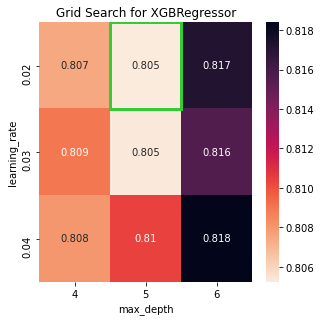

In [695]:
GS2.plot_search()

In [705]:
GS1._best_model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=1, gamma=None, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.03, max_delta_step=None, max_depth=5,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=308, n_jobs=80, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=1, silent=True, subsample=1,
             tree_method=None, validate_parameters=None, verbosity=0)

### Tune subsample, colsample_bytree and min_child_weight

In [737]:
xgb2 = XGBRegressor( learning_rate =0.03, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'reg:squarederror', scale_pos_weight=1, seed=27, verbosity = 0)

In [738]:
param_test3 = {
                'subsample' : [0.7,0.8,0.9, 1],
                'min_child_weight':[2, 3], 
                'colsample_bytree' : [0.1, 0.2, 0.3]
}


In [744]:
param_test3 = {
                'subsample' : [0.7,0.8,0.9, 1],
                'min_child_weight':list(range(1,10,2)), 
                'colsample_bytree' : [0.7,0.8,0.9, 1]
}


In [745]:
GS3 = XGBGridSearch(GS1._best_model, param_test3, cv=5)

In [746]:
GS3.fit(X, Y)

Fitting 5 folds for each of 80 candidates, totalling 400 candidates.
Fitting candidate 1 of 80
    colsample_bytree : 0.7     min_child_weight : 1     subsample : 0.7 
    Test Result: 0.8088     std: 0.0489       n iter: 306
    Train Result: 0.4233     std: 0.0057


Fitting candidate 2 of 80
    colsample_bytree : 0.7     min_child_weight : 1     subsample : 0.8 
    Test Result: 0.8081     std: 0.0477       n iter: 244
    Train Result: 0.4455     std: 0.0062


Fitting candidate 3 of 80
    colsample_bytree : 0.7     min_child_weight : 1     subsample : 0.9 
    Test Result: 0.8049     std: 0.0424       n iter: 325
    Train Result: 0.3874     std: 0.0076


Fitting candidate 4 of 80
    colsample_bytree : 0.7     min_child_weight : 1     subsample : 1 
    Test Result: 0.8075     std: 0.0387       n iter: 359
    Train Result: 0.3719     std: 0.0095


Fitting candidate 5 of 80
    colsample_bytree : 0.7     min_child_weight : 3     subsample : 0.7 
    Test Result: 0.8066     std: 0

    colsample_bytree : 0.9     min_child_weight : 1     subsample : 0.8 
    Test Result: 0.8091     std: 0.0518       n iter: 293
    Train Result: 0.4173     std: 0.0068


Fitting candidate 43 of 80
    colsample_bytree : 0.9     min_child_weight : 1     subsample : 0.9 
    Test Result: 0.8086     std: 0.0422       n iter: 325
    Train Result: 0.3870     std: 0.0078


Fitting candidate 44 of 80
    colsample_bytree : 0.9     min_child_weight : 1     subsample : 1 
    Test Result: 0.8069     std: 0.0411       n iter: 317
    Train Result: 0.3890     std: 0.0082


Fitting candidate 45 of 80
    colsample_bytree : 0.9     min_child_weight : 3     subsample : 0.7 
    Test Result: 0.8053     std: 0.0385       n iter: 600
    Train Result: 0.3285     std: 0.0145


Fitting candidate 46 of 80
    colsample_bytree : 0.9     min_child_weight : 3     subsample : 0.8 
    Test Result: 0.8063     std: 0.0494       n iter: 485
    Train Result: 0.3507     std: 0.0123


Fitting candidate 47 of 

array([[[0.808847 , 0.8081298, 0.8048564, 0.807482 ],
        [0.8065652, 0.8028648, 0.802311 , 0.8108934],
        [0.8068456, 0.803883 , 0.802875 , 0.8070142],
        [0.8051702, 0.8041406, 0.8003864, 0.806671 ],
        [0.8071664, 0.8071856, 0.8021542, 0.8039636]],

       [[0.808054 , 0.8080916, 0.804312 , 0.8055006],
        [0.8065892, 0.8038312, 0.8045734, 0.8076736],
        [0.8069364, 0.8045692, 0.8016932, 0.8083472],
        [0.8070692, 0.8039752, 0.8011318, 0.8087596],
        [0.8072602, 0.8054302, 0.7982938, 0.8052904]],

       [[0.8058548, 0.8090544, 0.8085852, 0.8068796],
        [0.8053298, 0.8062614, 0.804933 , 0.8081072],
        [0.803685 , 0.8080922, 0.8018118, 0.8079328],
        [0.8005632, 0.80559  , 0.8032848, 0.8027892],
        [0.801062 , 0.8046522, 0.8026912, 0.8062922]],

       [[0.8109794, 0.8115096, 0.806568 , 0.8052946],
        [0.803589 , 0.808567 , 0.8036696, 0.8107266],
        [0.805073 , 0.805102 , 0.8059498, 0.8077978],
        [0.8034968, 0.

In [749]:
GS3._best_params

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.03,
 'max_delta_step': None,
 'max_depth': 5,
 'min_child_weight': 9,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 451,
 'n_jobs': 80,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0,
 'seed': 1,
 'silent': True}

In [748]:
GS3._best_score

0.7982937999999999

In [751]:
param_test4 = {
    "max_depth" : [3, 5, 7, 9],
    "min_child_weight" : [3, 5, 7]
}

In [752]:
GS4 = XGBGridSearch(GS3._best_model, param_test4, cv=8)

In [ ]:
GS4.fit(X, Y)

Fitting 8 folds for each of 12 candidates, totalling 96 fits.
Fitting candidate 1 of 12
    max_depth : 3     min_child_weight : 3 
    Test Result: 0.8091     std: 0.0644       n iter: 600
    Train Result: 0.5126     std: 0.0073


Fitting candidate 2 of 12
    max_depth : 3     min_child_weight : 5 
    Test Result: 0.8083     std: 0.0630       n iter: 600
    Train Result: 0.5234     std: 0.0062


Fitting candidate 3 of 12
    max_depth : 3     min_child_weight : 7 
    Test Result: 0.8094     std: 0.0656       n iter: 600
    Train Result: 0.5327     std: 0.0064


Fitting candidate 4 of 12
    max_depth : 5     min_child_weight : 3 

We find that a minimum child weight of 5 and max depth of 5 are the optimal values. We continue by fine tuning our search by checking for 4-6 for each of the parameters. 

In [351]:
param_test2 = {
 'max_depth':list(range(4,7,1)),
 'min_child_weight':list(range(4,7,1))
}
GS2 = XGBGridSearch(xgb2, param_test2, cv=5)

In [352]:
GS2.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 candidates.
Fitting candidate 1 of 9
    max_depth : 4,     min_child_weight : 4, 
    Result: 0.7428     std: 0.0354
Fitting candidate 2 of 9
    max_depth : 4,     min_child_weight : 5, 
    Result: 0.7424     std: 0.0349
Fitting candidate 3 of 9
    max_depth : 4,     min_child_weight : 6, 
    Result: 0.7423     std: 0.0361
Fitting candidate 4 of 9
    max_depth : 5,     min_child_weight : 4, 
    Result: 0.7412     std: 0.0383
Fitting candidate 5 of 9
    max_depth : 5,     min_child_weight : 5, 
    Result: 0.7418     std: 0.0362
Fitting candidate 6 of 9
    max_depth : 5,     min_child_weight : 6, 
    Result: 0.7415     std: 0.0376
Fitting candidate 7 of 9
    max_depth : 6,     min_child_weight : 4, 
    Result: 0.7412     std: 0.0417
Fitting candidate 8 of 9
    max_depth : 6,     min_child_weight : 5, 
    Result: 0.7397     std: 0.0403
Fitting candidate 9 of 9
    max_depth : 6,     min_child_weight : 6, 
    Result: 0.

array([[0.7428166, 0.742351 , 0.742338 ],
       [0.7412128, 0.7418472, 0.7414978],
       [0.7412122, 0.739726 , 0.74263  ]])

(None,
 <AxesSubplot:title={'center':'Grid Search for XGBRegressor'}, xlabel='min_child_weight', ylabel='max_depth'>)

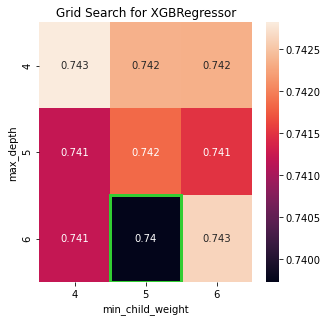

In [353]:
GS2.plot_search()

### Tune sample_bytree and sub_sample

In [354]:
param_test3 = {
 'sample_bytree':[0.6,0.8,0.9, 1],
 'sub_sample':[0.6,0.8,0.9, 1]
}

In [365]:
xgb3 = XGBRegressor( learning_rate =0.03, n_estimators=352, max_depth=6,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', scale_pos_weight=1, seed=27, verbosity = 0)

In [367]:
GS3 = XGBGridSearch(xgb3, param_test3, cv=5)

In [369]:
GS3.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 candidates.
Fitting candidate 1 of 16
    sample_bytree : 0.6,     sub_sample : 0.6, 
    Result: 0.7397     std: 0.0403
Best ^^^
Fitting candidate 2 of 16
    sample_bytree : 0.6,     sub_sample : 0.8, 
    Result: 0.7397     std: 0.0403
Fitting candidate 3 of 16
    sample_bytree : 0.6,     sub_sample : 0.9, 
    Result: 0.7397     std: 0.0403
Fitting candidate 4 of 16
    sample_bytree : 0.6,     sub_sample : 1, 
    Result: 0.7397     std: 0.0403
Fitting candidate 5 of 16
    sample_bytree : 0.8,     sub_sample : 0.6, 
    Result: 0.7397     std: 0.0403
Fitting candidate 6 of 16
    sample_bytree : 0.8,     sub_sample : 0.8, 
    Result: 0.7397     std: 0.0403
Fitting candidate 7 of 16
    sample_bytree : 0.8,     sub_sample : 0.9, 
    Result: 0.7397     std: 0.0403
Fitting candidate 8 of 16
    sample_bytree : 0.8,     sub_sample : 1, 
    Result: 0.7397     std: 0.0403
Fitting candidate 9 of 16
    sample_bytree : 0.9,     

KeyboardInterrupt: 

In [ ]:
GS3.plot_search()

### Learning rate and max_depth retuning

In [372]:
param_test4 = {
   'learning_rate' : [0.01, 0.03, 0.7, 0.1, 0.15],
    'max_depth' : [3,5]
}

In [373]:
#xgb4 = XGBRegressor(**GS3._best_params)
GS4 = XGBGridSearch(xgb3, param_test4, cv=5)

In [375]:
GS4.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 candidates.
Fitting candidate 1 of 10
    learning_rate : 0.01,     max_depth : 3, 
    Test Result: 0.7551     std: 0.0329       n iter: 500

   Train Result: 0.6050     std: 0.0076
Fitting candidate 2 of 10
    learning_rate : 0.01,     max_depth : 5, 
    Test Result: 0.7433     std: 0.0348       n iter: 500

   Train Result: 0.4786     std: 0.0077
Fitting candidate 3 of 10
    learning_rate : 0.03,     max_depth : 3, 
    Test Result: 0.7460     std: 0.0320       n iter: 500

   Train Result: 0.4804     std: 0.0095
Fitting candidate 4 of 10
    learning_rate : 0.03,     max_depth : 5, 
    Test Result: 0.7418     std: 0.0362       n iter: 369

   Train Result: 0.3706     std: 0.0085
Fitting candidate 5 of 10
    learning_rate : 0.7,     max_depth : 3, 
    Test Result: 0.8440     std: 0.0310       n iter: 3

   Train Result: 0.7274     std: 0.0138
Fitting candidate 6 of 10
    learning_rate : 0.7,     max_depth : 5, 
    Test 

array([[0.755059 , 0.743285 ],
       [0.7460378, 0.741847 ],
       [0.8440126, 0.8378552],
       [0.7527962, 0.7524692],
       [0.7615556, 0.761301 ]])

(None,
 <AxesSubplot:title={'center':'Grid Search for XGBRegressor'}, xlabel='max_depth', ylabel='learning_rate'>)

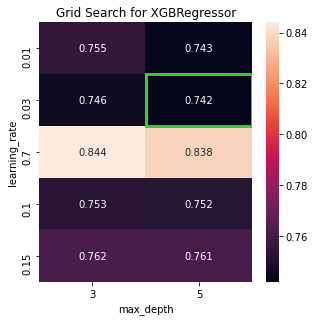

In [376]:
GS4.plot_search()

In [377]:
param_test5 = {
   'learning_rate' : [0.02, 0.025, 0.03, 0.035, 0.04],
    'max_depth' : [4,5,6]
}

xgb5 = XGBRegressor( learning_rate =0.03, n_estimators=352, max_depth=6,
 min_child_weight=5, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'reg:squarederror', scale_pos_weight=1, seed=27, verbosity = 0)

In [379]:
GS5 = XGBGridSearch(xgb5, param_test5, cv=5)

GS5.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 candidates.
Fitting candidate 1 of 15
    learning_rate : 0.02     max_depth : 4 
    Test Result: 0.7402     std: 0.0382       n iter: 785
   Train Result: 0.3882     std: 0.0117


Fitting candidate 2 of 15
    learning_rate : 0.02     max_depth : 5 
    Test Result: 0.7427     std: 0.0388       n iter: 677
   Train Result: 0.3313     std: 0.0115


Fitting candidate 3 of 15
    learning_rate : 0.02     max_depth : 6 
    Test Result: 0.7416     std: 0.0415       n iter: 724
   Train Result: 0.2585     std: 0.0079


Fitting candidate 4 of 15
    learning_rate : 0.025     max_depth : 4 
    Test Result: 0.7386     std: 0.0373       n iter: 610
   Train Result: 0.3918     std: 0.0122


Fitting candidate 5 of 15
    learning_rate : 0.025     max_depth : 5 
    Test Result: 0.7414     std: 0.0397       n iter: 575
   Train Result: 0.3227     std: 0.0102


Fitting candidate 6 of 15
    learning_rate : 0.025     max_depth : 6 
    Test 

array([[0.7401882, 0.742678 , 0.7415538],
       [0.7385784, 0.7413516, 0.7415422],
       [0.7425924, 0.7419322, 0.7440758],
       [0.7410332, 0.7418852, 0.7437156],
       [0.738755 , 0.7417882, 0.7438116]])

(None,
 <AxesSubplot:title={'center':'Grid Search for XGBRegressor'}, xlabel='max_depth', ylabel='learning_rate'>)

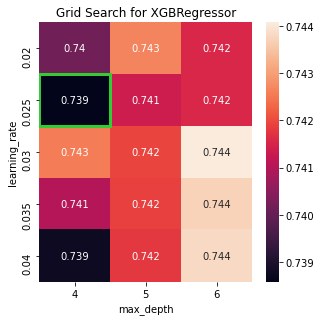

In [380]:
GS5.plot_search()

In [393]:
GS5._best_params["n_estimators"] = 610

# Best model

In [464]:
GS5._best_params

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.025,
 'max_delta_step': None,
 'max_depth': 4,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 610,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0,
 'seed': 27}

In [477]:
best_model = XGBRegressor(**GS5._best_params)

In [478]:
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:1.11559	validation_1-rmse:1.07326
[1]	validation_0-rmse:1.10404	validation_1-rmse:1.06439
[2]	validation_0-rmse:1.09291	validation_1-rmse:1.05607
[3]	validation_0-rmse:1.08217	validation_1-rmse:1.04649
[4]	validation_0-rmse:1.07174	validation_1-rmse:1.03898
[5]	validation_0-rmse:1.06130	validation_1-rmse:1.03047
[6]	validation_0-rmse:1.05153	validation_1-rmse:1.02299
[7]	validation_0-rmse:1.04174	validation_1-rmse:1.01432
[8]	validation_0-rmse:1.03246	validation_1-rmse:1.00801
[9]	validation_0-rmse:1.02348	validation_1-rmse:1.00154
[10]	validation_0-rmse:1.01429	validation_1-rmse:0.99491
[11]	validation_0-rmse:1.00520	validation_1-rmse:0.98686
[12]	validation_0-rmse:0.99703	validation_1-rmse:0.98111
[13]	validation_0-rmse:0.98894	validation_1-rmse:0.97410
[14]	validation_0-rmse:0.98072	validation_1-rmse:0.96883
[15]	validation_0-rmse:0.97267	validation_1-rmse:0.96258
[16]	validation_0-rmse:0.96547	validation_1-rmse:0.95693
[17]	validation_0-rmse:0.95836	validation

[144]	validation_0-rmse:0.63039	validation_1-rmse:0.77786
[145]	validation_0-rmse:0.62926	validation_1-rmse:0.77756
[146]	validation_0-rmse:0.62841	validation_1-rmse:0.77708
[147]	validation_0-rmse:0.62732	validation_1-rmse:0.77703
[148]	validation_0-rmse:0.62652	validation_1-rmse:0.77693
[149]	validation_0-rmse:0.62512	validation_1-rmse:0.77681
[150]	validation_0-rmse:0.62417	validation_1-rmse:0.77660
[151]	validation_0-rmse:0.62305	validation_1-rmse:0.77657
[152]	validation_0-rmse:0.62221	validation_1-rmse:0.77638
[153]	validation_0-rmse:0.62107	validation_1-rmse:0.77610
[154]	validation_0-rmse:0.62031	validation_1-rmse:0.77588
[155]	validation_0-rmse:0.61951	validation_1-rmse:0.77543
[156]	validation_0-rmse:0.61871	validation_1-rmse:0.77537
[157]	validation_0-rmse:0.61793	validation_1-rmse:0.77501
[158]	validation_0-rmse:0.61689	validation_1-rmse:0.77499
[159]	validation_0-rmse:0.61566	validation_1-rmse:0.77501
[160]	validation_0-rmse:0.61458	validation_1-rmse:0.77482
[161]	validati

[286]	validation_0-rmse:0.54700	validation_1-rmse:0.76566
[287]	validation_0-rmse:0.54661	validation_1-rmse:0.76564
[288]	validation_0-rmse:0.54625	validation_1-rmse:0.76569
[289]	validation_0-rmse:0.54583	validation_1-rmse:0.76567
[290]	validation_0-rmse:0.54529	validation_1-rmse:0.76565
[291]	validation_0-rmse:0.54458	validation_1-rmse:0.76567
[292]	validation_0-rmse:0.54401	validation_1-rmse:0.76564
[293]	validation_0-rmse:0.54365	validation_1-rmse:0.76562
[294]	validation_0-rmse:0.54346	validation_1-rmse:0.76565
[295]	validation_0-rmse:0.54285	validation_1-rmse:0.76577
[296]	validation_0-rmse:0.54240	validation_1-rmse:0.76579
[297]	validation_0-rmse:0.54217	validation_1-rmse:0.76571
[298]	validation_0-rmse:0.54171	validation_1-rmse:0.76563
[299]	validation_0-rmse:0.54118	validation_1-rmse:0.76535
[300]	validation_0-rmse:0.54078	validation_1-rmse:0.76525
[301]	validation_0-rmse:0.54031	validation_1-rmse:0.76536
[302]	validation_0-rmse:0.53987	validation_1-rmse:0.76527
[303]	validati

[428]	validation_0-rmse:0.49484	validation_1-rmse:0.76205
[429]	validation_0-rmse:0.49444	validation_1-rmse:0.76207
[430]	validation_0-rmse:0.49409	validation_1-rmse:0.76194
[431]	validation_0-rmse:0.49366	validation_1-rmse:0.76201
[432]	validation_0-rmse:0.49353	validation_1-rmse:0.76194
[433]	validation_0-rmse:0.49328	validation_1-rmse:0.76194
[434]	validation_0-rmse:0.49285	validation_1-rmse:0.76194
[435]	validation_0-rmse:0.49248	validation_1-rmse:0.76198
[436]	validation_0-rmse:0.49202	validation_1-rmse:0.76202
[437]	validation_0-rmse:0.49186	validation_1-rmse:0.76202
[438]	validation_0-rmse:0.49142	validation_1-rmse:0.76200
[439]	validation_0-rmse:0.49107	validation_1-rmse:0.76195
[440]	validation_0-rmse:0.49071	validation_1-rmse:0.76191
[441]	validation_0-rmse:0.49042	validation_1-rmse:0.76203
[442]	validation_0-rmse:0.49010	validation_1-rmse:0.76205
[443]	validation_0-rmse:0.48979	validation_1-rmse:0.76215
[444]	validation_0-rmse:0.48950	validation_1-rmse:0.76219
[445]	validati

[570]	validation_0-rmse:0.45287	validation_1-rmse:0.76233
[571]	validation_0-rmse:0.45262	validation_1-rmse:0.76228
[572]	validation_0-rmse:0.45234	validation_1-rmse:0.76230
[573]	validation_0-rmse:0.45195	validation_1-rmse:0.76228
[574]	validation_0-rmse:0.45168	validation_1-rmse:0.76231
[575]	validation_0-rmse:0.45138	validation_1-rmse:0.76232
[576]	validation_0-rmse:0.45117	validation_1-rmse:0.76227
[577]	validation_0-rmse:0.45096	validation_1-rmse:0.76222
[578]	validation_0-rmse:0.45066	validation_1-rmse:0.76221
[579]	validation_0-rmse:0.45047	validation_1-rmse:0.76221
[580]	validation_0-rmse:0.45025	validation_1-rmse:0.76221
[581]	validation_0-rmse:0.44998	validation_1-rmse:0.76225
[582]	validation_0-rmse:0.44981	validation_1-rmse:0.76229
[583]	validation_0-rmse:0.44957	validation_1-rmse:0.76231
[584]	validation_0-rmse:0.44916	validation_1-rmse:0.76230
[585]	validation_0-rmse:0.44878	validation_1-rmse:0.76228
[586]	validation_0-rmse:0.44850	validation_1-rmse:0.76223
[587]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.025, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=610, n_jobs=96, num_parallel_tree=1, random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=0)

In [479]:
y_pred_test = best_model.predict(X_test)

In [480]:
y_pred_train = best_model.predict(X_train)

(<Figure size 4200x3000 with 4 Axes>,
 <AxesSubplot:title={'center':'XGBOOST Regression Error'}, xlabel='Nbr of trees (n_estimators)', ylabel='error : RMSE'>)

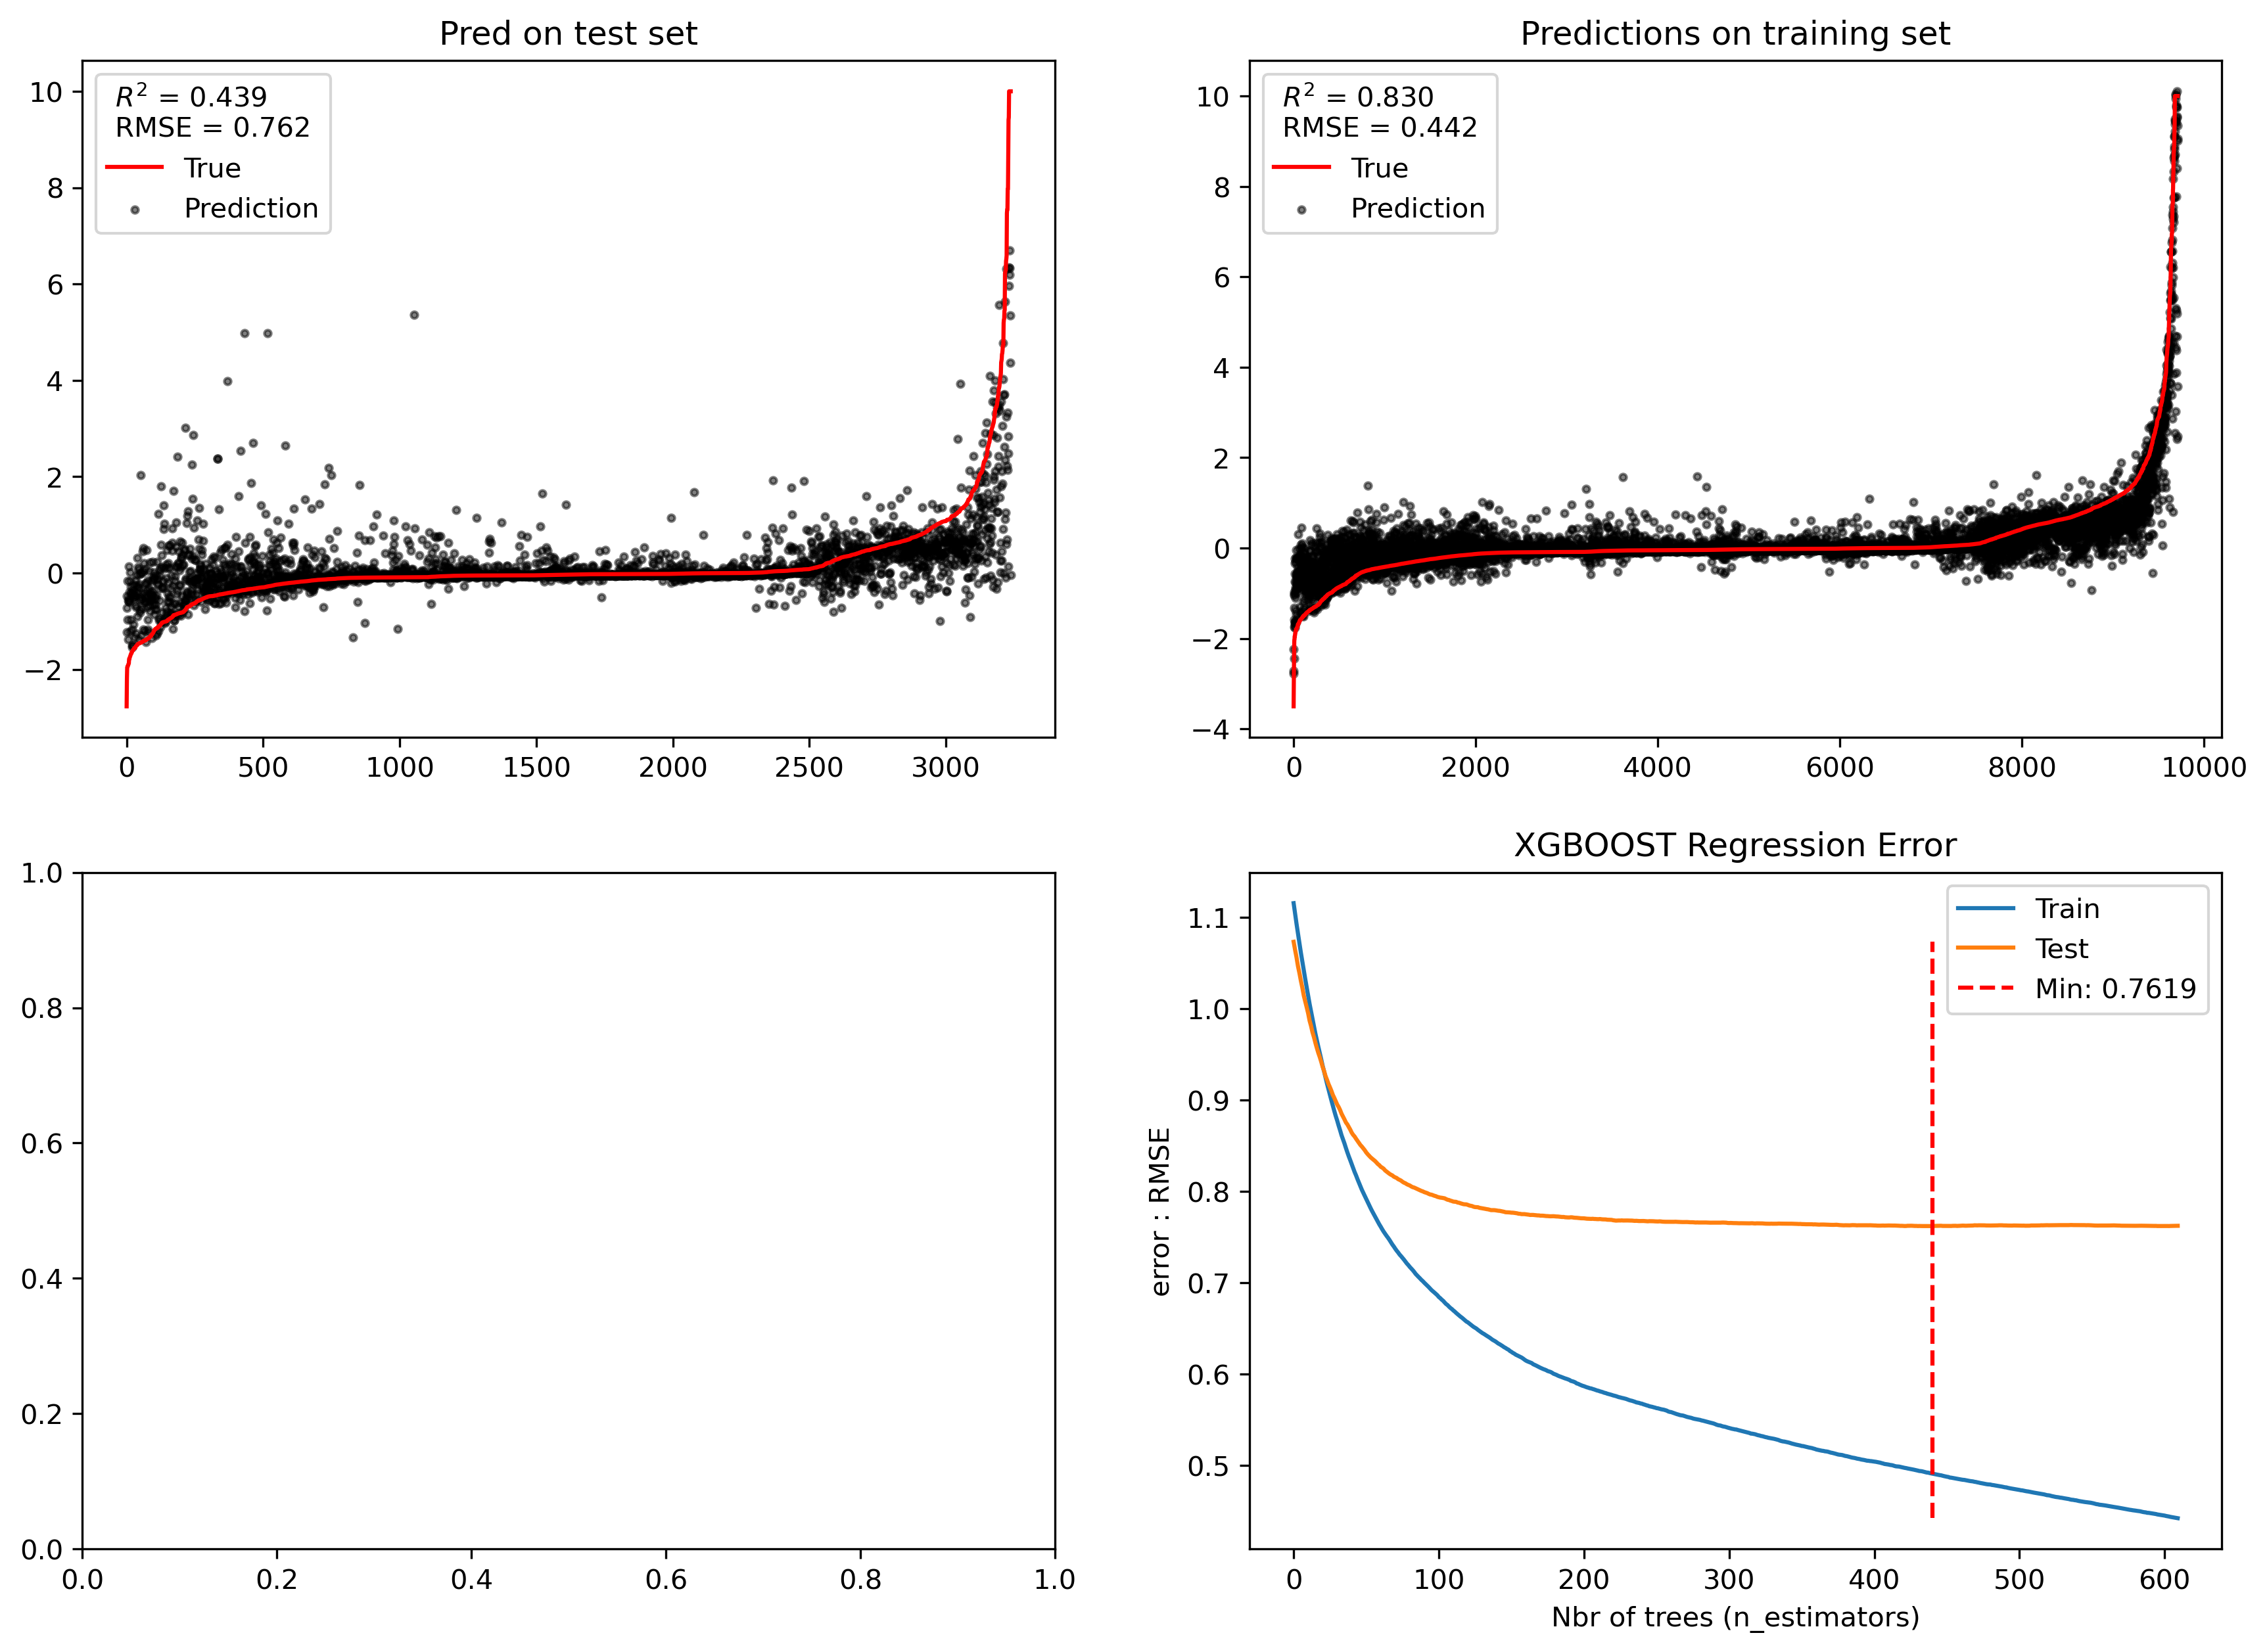

In [481]:
fig, axes = plt.subplots(2,2, figsize=(14,10), dpi=300)
plot_prediction(y_test, y_pred_test, fig=fig, ax=axes[0][0], title="Pred on test set");
plot_prediction(y_train, y_pred_train, fig=fig, ax=axes[0][1], title="Predictions on training set");
#plot_prediction(y_train, y_pred_xgb_train, fig=fig, ax=axes[0][1], title="Pred on train");
plot_training_xgb(best_model.evals_result_, fig=fig, ax=axes[1][1], title="Training error")
#fig.savefig("predictions.png", dpi=300)

### Cross validated best model

In [484]:
best_model_cv = xgb.cv(best_model.get_params(), xgb.DMatrix(X, label=Y), num_boost_round=best_model.get_params()['n_estimators'])

In [485]:
best_model_cv.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
605,0.414584,0.018151,0.815579,0.022295
606,0.414282,0.018127,0.815554,0.022301
607,0.414051,0.018072,0.815627,0.022269
608,0.413794,0.018084,0.815609,0.022278
609,0.413444,0.018109,0.815572,0.022333


# Feature selection with Hypetune

In [492]:
from scipy import stats
from shaphypetune import BoostSearch, BoostRFE

In [ ]:
param_dist = {'n_estimators': 450,
              'learning_rate': [0.02, 0.03, 0.04],
              'max_depth': [3, 4]}

model = BoostRFE(XGBRegressor(), param_grid=param_dist, n_iter=10, sampling_seed=0,
                 min_features_to_select=100, step=1)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=1)


6 trials detected for ('n_estimators', 'learning_rate', 'max_depth')

[0]	validation_0-rmse:1.07465
[1]	validation_0-rmse:1.06704
[2]	validation_0-rmse:1.05975
[3]	validation_0-rmse:1.05326
[4]	validation_0-rmse:1.04601
[5]	validation_0-rmse:1.03990
[6]	validation_0-rmse:1.03305
[7]	validation_0-rmse:1.02764
[8]	validation_0-rmse:1.02158
[9]	validation_0-rmse:1.01528
[10]	validation_0-rmse:1.00951
[11]	validation_0-rmse:1.00468
[12]	validation_0-rmse:0.99929
[13]	validation_0-rmse:0.99456
[14]	validation_0-rmse:0.98888
[15]	validation_0-rmse:0.98386
[16]	validation_0-rmse:0.97948
[17]	validation_0-rmse:0.97506
[18]	validation_0-rmse:0.97059
[19]	validation_0-rmse:0.96599
[20]	validation_0-rmse:0.96160
[21]	validation_0-rmse:0.95700
[22]	validation_0-rmse:0.95300
[23]	validation_0-rmse:0.94941
[24]	validation_0-rmse:0.94552
[25]	validation_0-rmse:0.94159
[26]	validation_0-rmse:0.93830
[27]	validation_0-rmse:0.93461
[28]	validation_0-rmse:0.93102
[29]	validation_0-rmse:0.92759
[30]	vali

In [1]:
from shap.utils._general import approximate_interactions

Guide on interaction function:  
https://github.com/slundberg/shap/blob/master/shap/utils/_general.py

In [514]:
cv_input_matrix = xgb.DMatrix(X, label=Y)

In [564]:
best_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.025,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 610,
 'n_jobs': 96,
 'num_parallel_tree': 1,
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'seed': 27}

In [525]:
cv_result = xgb.cv(best_model.get_params(),
                   cv_input_matrix,
                   num_boost_round=400,
                   verbose_eval=True,
                   early_stopping_rounds=80,
                   metrics="rmse",
                   nfold=2)

[0]	train-rmse:1.10381+0.03044	test-rmse:1.10710+0.03034
[1]	train-rmse:1.09200+0.02969	test-rmse:1.09878+0.02926
[2]	train-rmse:1.08060+0.02893	test-rmse:1.09055+0.02855
[3]	train-rmse:1.06961+0.02821	test-rmse:1.08273+0.02737
[4]	train-rmse:1.05871+0.02777	test-rmse:1.07514+0.02701
[5]	train-rmse:1.04832+0.02705	test-rmse:1.06780+0.02643
[6]	train-rmse:1.03812+0.02665	test-rmse:1.06114+0.02573
[7]	train-rmse:1.02844+0.02596	test-rmse:1.05465+0.02508
[8]	train-rmse:1.01891+0.02561	test-rmse:1.04866+0.02437
[9]	train-rmse:1.00972+0.02513	test-rmse:1.04268+0.02380
[10]	train-rmse:1.00089+0.02468	test-rmse:1.03722+0.02327
[11]	train-rmse:0.99217+0.02413	test-rmse:1.03163+0.02311
[12]	train-rmse:0.98357+0.02404	test-rmse:1.02646+0.02236
[13]	train-rmse:0.97518+0.02346	test-rmse:1.02129+0.02209
[14]	train-rmse:0.96665+0.02292	test-rmse:1.01585+0.02213
[15]	train-rmse:0.95891+0.02217	test-rmse:1.01085+0.02249
[16]	train-rmse:0.95087+0.02174	test-rmse:1.00602+0.02268
[17]	train-rmse:0.94289+

[141]	train-rmse:0.59129+0.01482	test-rmse:0.84519+0.01538
[142]	train-rmse:0.59032+0.01480	test-rmse:0.84494+0.01546
[143]	train-rmse:0.58949+0.01484	test-rmse:0.84477+0.01546
[144]	train-rmse:0.58831+0.01475	test-rmse:0.84447+0.01551
[145]	train-rmse:0.58729+0.01488	test-rmse:0.84431+0.01557
[146]	train-rmse:0.58642+0.01518	test-rmse:0.84404+0.01541
[147]	train-rmse:0.58532+0.01544	test-rmse:0.84387+0.01520
[148]	train-rmse:0.58427+0.01559	test-rmse:0.84367+0.01508
[149]	train-rmse:0.58314+0.01572	test-rmse:0.84335+0.01504
[150]	train-rmse:0.58212+0.01572	test-rmse:0.84310+0.01505
[151]	train-rmse:0.58125+0.01571	test-rmse:0.84296+0.01500
[152]	train-rmse:0.58009+0.01582	test-rmse:0.84280+0.01510
[153]	train-rmse:0.57913+0.01599	test-rmse:0.84262+0.01499
[154]	train-rmse:0.57795+0.01623	test-rmse:0.84240+0.01504
[155]	train-rmse:0.57707+0.01630	test-rmse:0.84237+0.01490
[156]	train-rmse:0.57590+0.01629	test-rmse:0.84218+0.01474
[157]	train-rmse:0.57486+0.01649	test-rmse:0.84197+0.014

[280]	train-rmse:0.49313+0.02823	test-rmse:0.83461+0.00957
[281]	train-rmse:0.49261+0.02827	test-rmse:0.83456+0.00948
[282]	train-rmse:0.49208+0.02816	test-rmse:0.83449+0.00946
[283]	train-rmse:0.49177+0.02824	test-rmse:0.83445+0.00939
[284]	train-rmse:0.49134+0.02840	test-rmse:0.83435+0.00935
[285]	train-rmse:0.49067+0.02835	test-rmse:0.83439+0.00939
[286]	train-rmse:0.49031+0.02832	test-rmse:0.83439+0.00936
[287]	train-rmse:0.48981+0.02838	test-rmse:0.83427+0.00933
[288]	train-rmse:0.48927+0.02845	test-rmse:0.83425+0.00937
[289]	train-rmse:0.48897+0.02846	test-rmse:0.83424+0.00937
[290]	train-rmse:0.48848+0.02858	test-rmse:0.83428+0.00936
[291]	train-rmse:0.48804+0.02854	test-rmse:0.83427+0.00936
[292]	train-rmse:0.48757+0.02850	test-rmse:0.83428+0.00934
[293]	train-rmse:0.48714+0.02858	test-rmse:0.83425+0.00936
[294]	train-rmse:0.48662+0.02863	test-rmse:0.83420+0.00933
[295]	train-rmse:0.48619+0.02864	test-rmse:0.83424+0.00931
[296]	train-rmse:0.48573+0.02884	test-rmse:0.83425+0.009

In [560]:
cv_results = pd.DataFrame(columns=['train-rmse-mean', 'train-rmse-std', 'test-rmse-mean', 'test-rmse-std'])


In [557]:
cv_result.shape[0]

400

In [561]:
cv_results = cv_results.append(cv_result.iloc[-1])
cv_results = cv_results.rename(index={cv_result.shape[0]-1:"ESR1"})

In [562]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
ESR1,0.440771,0.033091,0.833013,0.008361


In [559]:
cv_result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.103808,0.030436,1.107101,0.030336
1,1.091998,0.029685,1.098778,0.029264
2,1.080599,0.028933,1.090551,0.028549
3,1.069606,0.028206,1.082727,0.027366
4,1.058709,0.027775,1.075141,0.027009
...,...,...,...,...
395,0.442560,0.032622,0.833268,0.008203
396,0.441974,0.032712,0.833164,0.008275
397,0.441570,0.032884,0.833173,0.008319
398,0.441172,0.033026,0.833115,0.008358


In [563]:
type(["ss", "sa"]) is list

True

In [565]:
import src.model_builder as mb

In [567]:
model_x = mb.CellLevelModel("Cancer", ["ESR1"])

In [570]:
model_x.build_model(params, cv=0)

CANCER
['ESR1']
-----ESR1-----
Building predicting model for ESR1


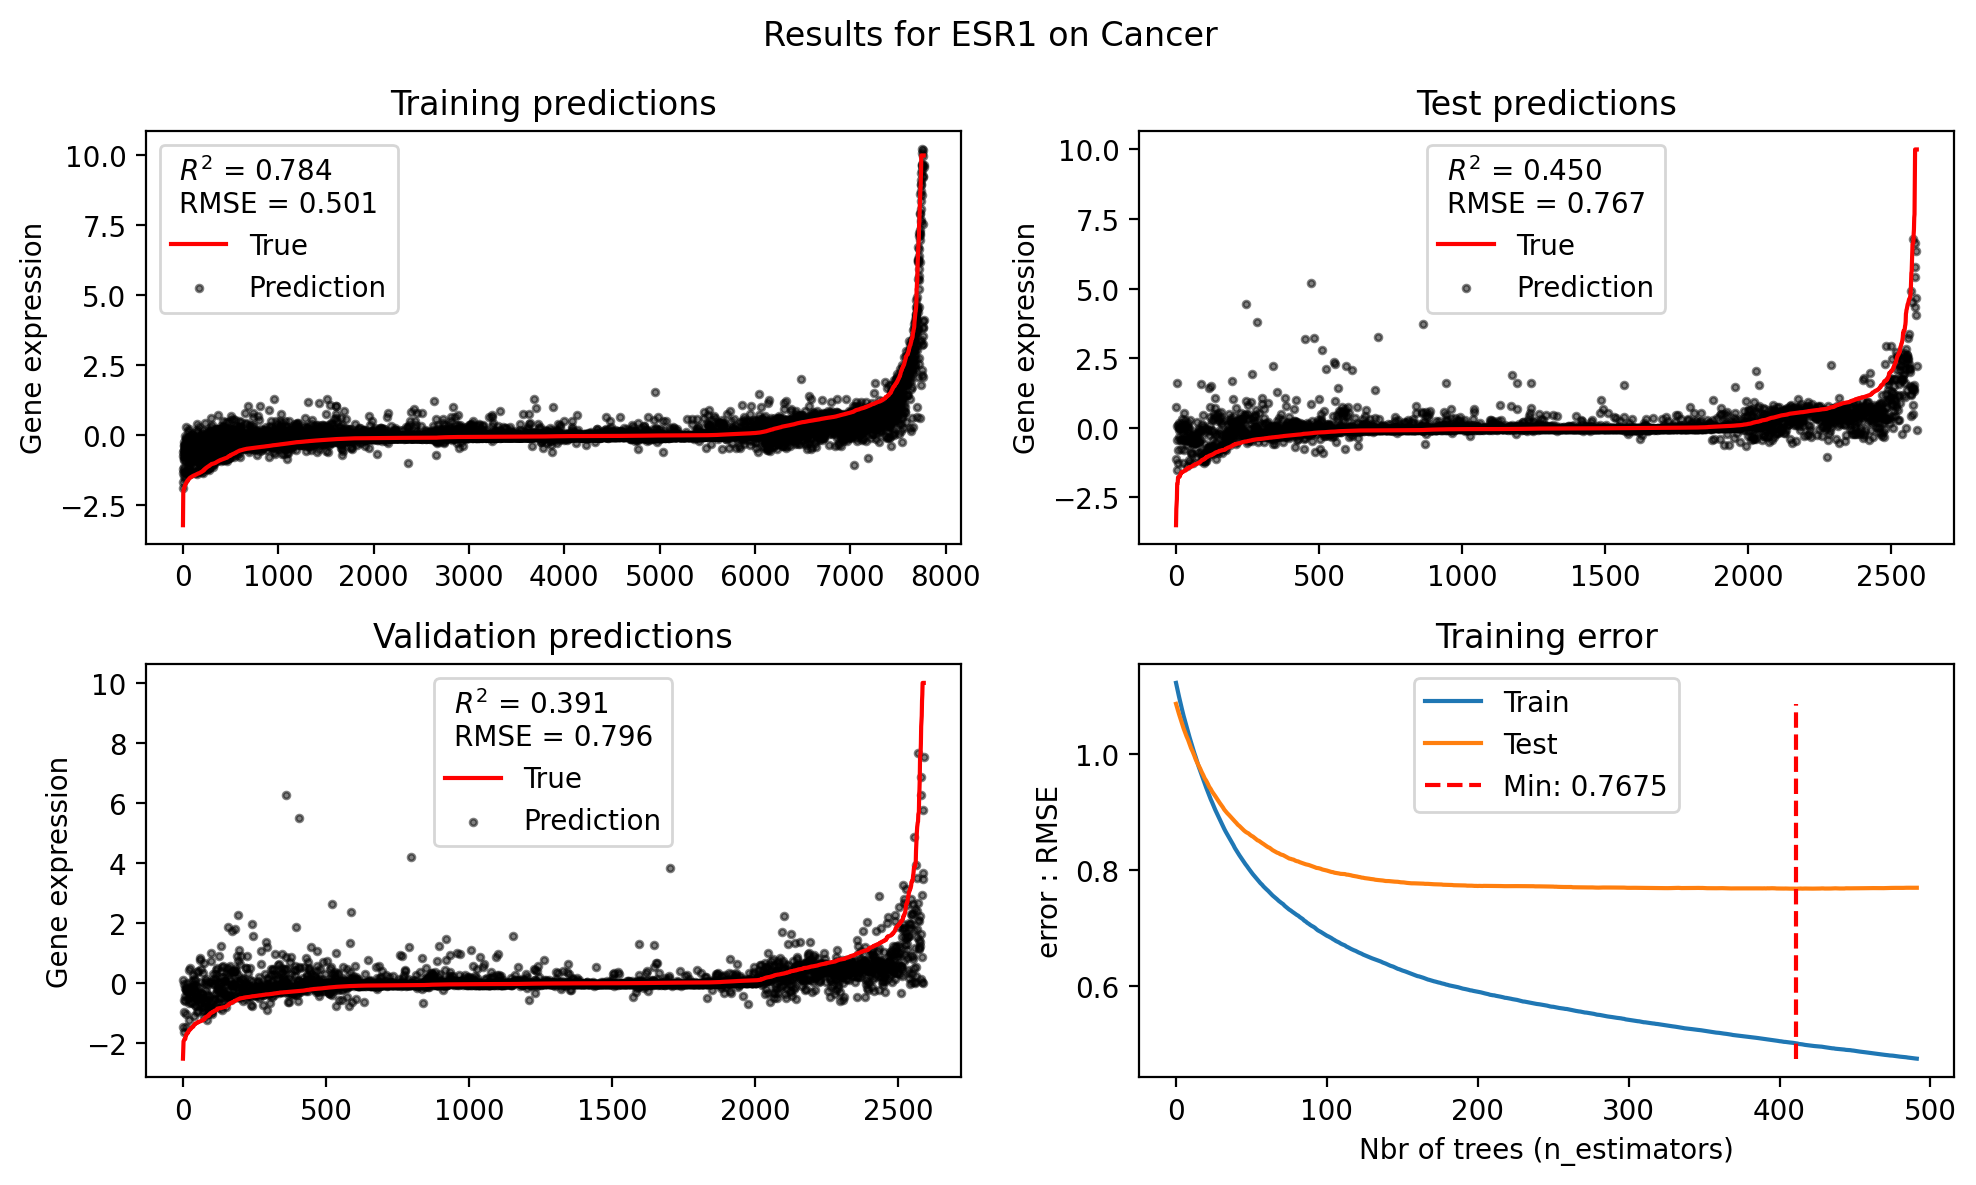

In [571]:
model_x.plot_results("ESR1")

In [657]:
model_x.shap_analysis("ESR1")

In [661]:
model_x.explainer.shap_values

<bound method Tree.shap_values of <shap.explainers._tree.Tree object at 0x7fd3b81fd400>>

In [577]:
shap_values = model_x.shap_vals["ESR1"]

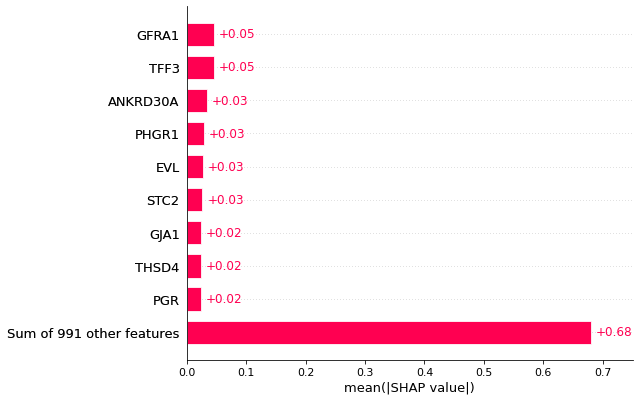

In [579]:
model_x.shap_plot_bar("ESR1")

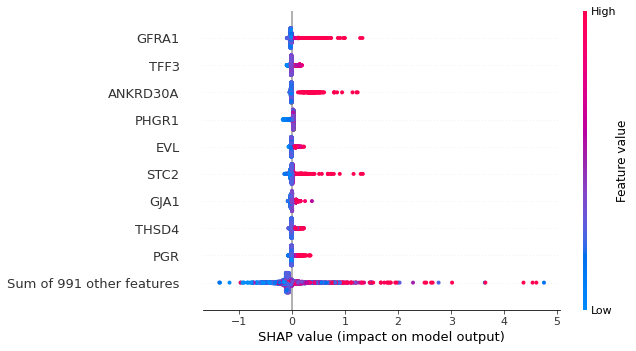

In [580]:
model_x.shap_plot_beeswarm("ESR1")

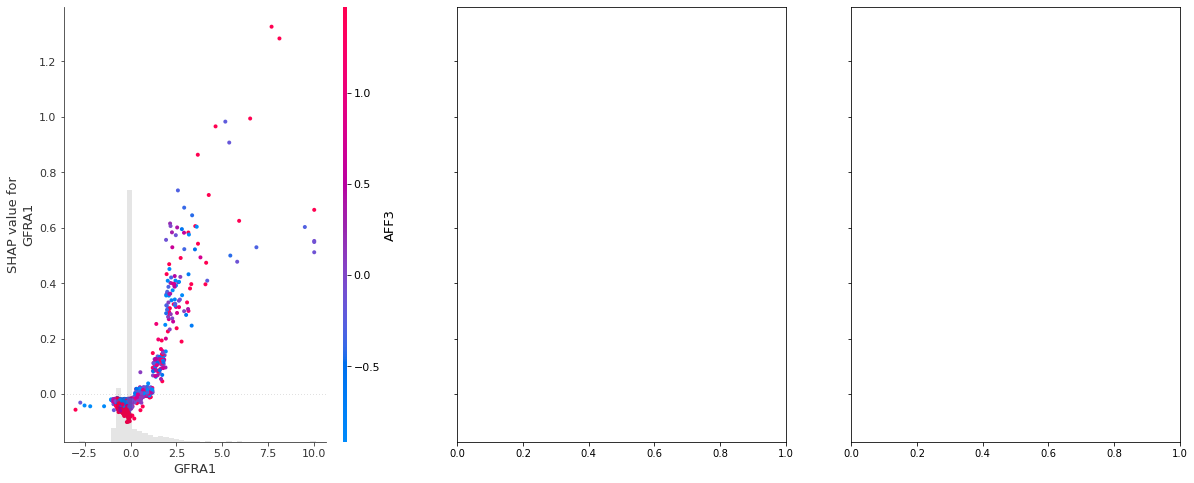

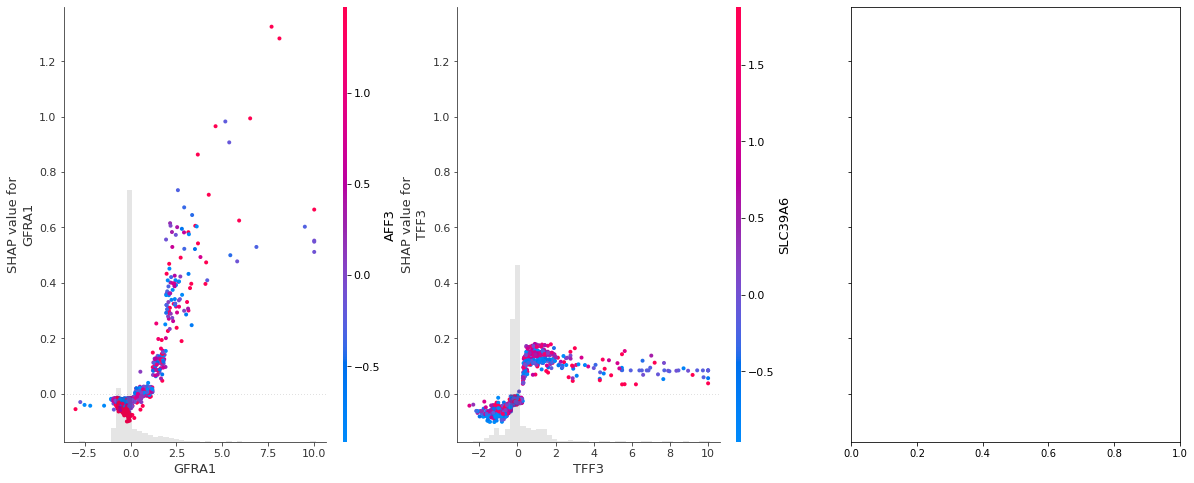

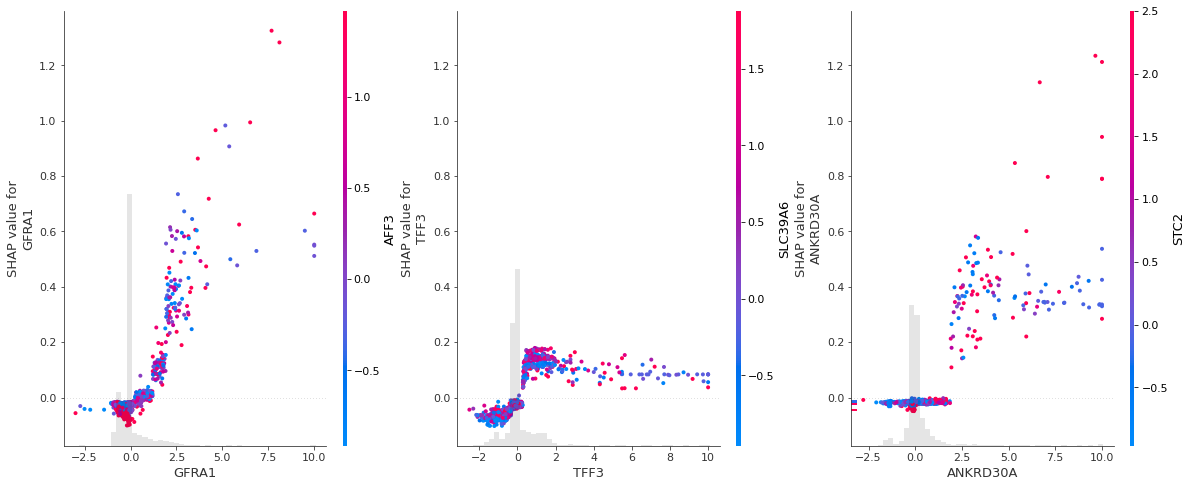

In [586]:
model_x.shap_scatter("ESR1", ["GFRA1", "TFF3", "ANKRD30A"]);

In [634]:
index = [i for i, col in enumerate(X.columns) if col == "TFF3"][0]

In [619]:
from shap.utils._general import approximate_interactions, potential_interactions

In [612]:
"GFRA1" in model_x.datasets["ESR1"][2].iloc[:,900:999].columns

True

In [635]:
interactions = potential_interactions(shap_values[:,index], shap_values)

In [650]:
ranked_interactions

array([978, 958, 592, 370, 209, 392, 742,  38, 996, 328, 504, 929, 828,
       994, 765, 924, 584, 739, 340, 330, 950, 314, 204, 679, 203, 789,
        68, 914,  52, 855, 975, 868, 969, 147, 758, 316, 464, 471, 122,
       382, 772, 127, 408, 233, 562, 426, 887, 777, 723, 716, 939, 185,
       266, 393, 541, 712, 948, 549, 156, 462, 822, 563, 827, 972, 251,
       820,  15, 671, 998, 415, 457, 363, 949, 117, 876, 788, 445, 920,
       436, 422,  48, 371, 237, 866, 730, 664, 961,  43, 816, 848,  14,
       756, 444, 372,  30, 912, 565, 188, 990, 242, 743, 550, 355,  96,
       446, 292, 339, 993, 225, 532, 348, 448, 624, 442, 139, 797, 232,
       535, 529, 169, 973, 869, 632, 731, 693, 398, 930, 779, 542, 629,
       709, 142,  36, 218,  26, 598, 428,  71, 152, 374, 649, 720, 441,
       983, 124, 397, 608, 773, 965, 613, 832, 481, 886, 576, 997, 627,
       849, 802, 976, 798, 526, 740, 656, 143, 842, 230, 968, 727, 493,
       546, 982,  10, 323, 970, 501, 704, 473, 668, 781, 985, 90

In [644]:
X.columns

Index(['TMEM181', 'CLGN', 'BAG1', 'CENPP', 'PLS1', 'IER2', 'SULT1A1', 'MOK',
       'MISP', 'CCDC57',
       ...
       'PI15', 'SPDEF', 'LINC00993', 'MLPH', 'AR', 'CAPN8', 'GFRA1', 'AFF3',
       'STC2', 'ANKRD30A'],
      dtype='object', name='Genes', length=1000)

In [647]:
shap_values.values

array([[ 9.0387410e-05, -5.4046902e-04, -1.1963300e-05, ...,
        -7.8893118e-03, -6.4169336e-03, -1.4612371e-02],
       [ 9.5716467e-05,  1.1416404e-04, -1.1963300e-05, ...,
        -7.5854780e-03, -6.5163528e-03, -1.4718538e-02],
       [ 9.3165814e-05, -5.3894368e-04, -1.1963300e-05, ...,
        -7.8859748e-03, -7.0530851e-03, -1.4684780e-02],
       ...,
       [-3.9723735e-05, -5.3620373e-04, -1.1963300e-05, ...,
        -7.7811722e-03, -6.8641999e-03, -1.4705786e-02],
       [ 9.3165814e-05, -5.3894368e-04, -1.1963300e-05, ...,
        -8.6589539e-03, -6.8601710e-03, -1.4448310e-02],
       [-3.7832750e-05, -5.3545454e-04, -1.1963300e-05, ...,
        -7.8455415e-03, -7.8554386e-03, -1.4859707e-02]], dtype=float32)

In [648]:
interactions = approximate_interactions(index, shap_values.values, model_x.datasets["ESR1"][2])

In [569]:
params = {'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.025,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 5,
 'missing': float("nan"),
 'monotone_constraints': '()',
 'n_estimators': 1000,
 'n_jobs': 90,
 'num_parallel_tree': 1,
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'seed': None}

In [760]:
d = pd.DataFrame(np.arange(36).reshape((9,4)), columns = ["a", "b", "c", "d"])

In [761]:
d["c"].reshape(3,3)

0     2
1     6
2    10
3    14
4    18
5    22
6    26
7    30
8    34
Name: c, dtype: int64